In [1]:
# Pre-processing
import collections
import numpy as np
import pandas as pd
import math

# General visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Geospatial visualization
import geopandas as gpd
import shapely
from shapely.geometry import Point
from geopy.geocoders import GoogleV3
from scipy import ndimage

In [17]:
# Display otpions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)
np.set_printoptions(linewidth=100)

In [18]:
# 10 primary (more important) tables
primaryTables = [
    'nibrs_arrestee', 'nibrs_bias_motivation', 'nibrs_incident', 'nibrs_offender', 'nibrs_offense',
    'nibrs_property_desc', 'nibrs_property', 'nibrs_victim_injury', 'nibrs_victim_offender_rel', 'nibrs_victim'
]

# 24 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    'nibrs_activity_type': ('activity_type_id', 'activity_type_name'),
    'nibrs_age': ('age_id', 'age_name'),
    'nibrs_arrest_type': ('arrest_type_id', 'arrest_type_name'), 
    'nibrs_assignment_type': ('assignment_type_id', 'assignment_type_name'),
    'nibrs_bias_list': ('bias_id', 'bias_name'),
    'nibrs_circumstances': ('circumstances_id', 'circumstances_name'),
    'nibrs_cleared_except': ('cleared_except_id', 'cleared_except_name'),
    'nibrs_criminal_act_type': ('criminal_act_id', 'criminal_act_name'),
    'nibrs_drug_measure_type': ('drug_measure_type_id', 'drug_measure_name'),
    'nibrs_ethnicity': ('ethnicity_id', 'ethnicity_name'),
    'nibrs_injury': ('injury_id', 'injury_name'),
    'nibrs_justifiable_force': ('justifiable_force_id', 'justifiable_force_name'),
    'nibrs_location_type': ('location_id', 'location_name'),
    'nibrs_month': ('nibrs_month_id', 'month_num'),
    'nibrs_offense_type' : ('offense_type_id', 'offense_name'),
    'nibrs_prop_desc_type': ('prop_desc_id', 'prop_desc_name'),
    'nibrs_prop_loss_type': ('prop_loss_id', 'prop_loss_name'),
    'nibrs_relationship': ('relationship_id', 'relationship_name'),
    'nibrs_suspected_drug_type': ('suspected_drug_type_id', 'suspected_drug_name'),
    'nibrs_using_list': ('suspect_using_id', 'suspect_using_name'),
    'nibrs_victim_type': ('victim_type_id', 'victim_type_name'),
    'nibrs_weapon_type': ('weapon_id', 'weapon_name'),
    'ref_race': ('race_id', 'race_desc'),
    'ref_state': ('state_id', 'state_name')
}

# 9 secondary (less important) tables
secondaryTables = [
    'agency_participation', 'cde_agencies', 'nibrs_arrestee_weapon', 'nibrs_criminal_act', 'nibrs_suspected_drug',
    'nibrs_suspect_using', 'nibrs_victim_circumstances', 'nibrs_victim_offense', 'nibrs_weapon'
]

In [19]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., PA-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

# PA2016 = readCSVs('PA-2016')
SC2016 = readCSVs('SC-2016')

Reading all CSVs for SC-2016 dataset...
Finished reading 43 CSVs


In [20]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(SC2016)
# maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 24 lookup tables


In [21]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        oldCol, newCol = lookupTables[lookupTableName]
        # dic: the nested dictionary required by df.replace()
        dic = {oldCol: maps[(oldCol, newCol)]}
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and Renaming columns...')
replaceAndRename(SC2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(SC2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(SC2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim'], ['nibrs_victim_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(SC2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(SC2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Replacing and Renaming columns...
Done


Next we will create a dataframe containing all the columns with meaningful information associated with incident, victim, offender and offense.

In [22]:
# Select valid ages and rename some column so as not to mess up with offender's information
def formalizePersonalInfo(rawDF, identity):
    return rawDF[rawDF['age_id'] == 5.0].drop('age_id', axis=1)\
.rename(columns={"age_num": identity + "_age","sex_code": identity + "_sex", "race_desc": identity + "_race", \
                "ethnicity_name": identity + "_ethnicity", "resident_status_code": identity + "_resident_status"})

# First select the data frame with victim_id and offender_id, and merge other dataframes into it by matching victim_id.
dataframe = formalizePersonalInfo(SC2016["nibrs_victim_offender_rel"].merge(SC2016['nibrs_victim'], how='left', on='victim_id')\
                                  .merge(SC2016['nibrs_incident'], how='left', on='incident_id')\
                                  [['victim_id', 'offender_id', 'incident_id', 'relationship_name',\
                                    'victim_seq_num', 'victim_type_name','age_id', 'age_num', 'sex_code','month_num', \
                                    'race_desc', 'ethnicity_name', 'resident_status_code', 'incident_date']], 'victim')

# Continue merge dataframes to diversify the information
dataframe = formalizePersonalInfo(dataframe.merge(SC2016['nibrs_victim_injury'], how = 'left', on = 'victim_id')
                                  .merge(SC2016['nibrs_injury'], how = 'left', on = 'injury_id')\
                                  .drop(['injury_id', 'injury_code'], axis=1)\
                                  .merge(SC2016['nibrs_offender'], how = 'left',\
                                         on = ['incident_id', 'offender_id'])\
                                  .drop(['ff_line_number', 'age_range_low_num', 'age_range_high_num'], axis = 1)\
                                  .merge(SC2016['nibrs_offense'], how = 'left', on = 'incident_id')\
                                  .drop(['attempt_complete_flag', 'location_name', 'num_premises_entered',\
                                         'method_entry_code', 'ff_line_number'], axis=1)\
                                  .merge(SC2016['nibrs_bias_motivation'], how = 'left', on = 'offense_id')\
                                  .merge(SC2016['nibrs_bias_list'], how = 'left', on = 'bias_id')\
                                  .drop(['victim_id', 'offender_id', 'incident_id', 'offense_id', 'bias_id',\
                                         'bias_code'], axis=1), 'offender')

dataframe.tail()

,relationship_name,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,incident_date,injury_name,offender_seq_num,offender_age,offender_sex,offender_race,offender_ethnicity,offense_name,bias_name
152634,Victim Was Stranger,2,Individual,24.0,F,12,Black or African American,Not Hispanic or Latino,N,2016-12-06 00:00:00,None,1,29.0,F,Black or African American,Not Hispanic or Latino,Simple Assault,None
152635,Victim Was Acquaintance,1,Individual,57.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None
152636,Victim Was Acquaintance,1,Individual,57.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152637,Victim Was Acquaintance,2,Individual,43.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152638,Victim Was Acquaintance,2,Individual,43.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None


Select the data size and shuffle the data.

In [23]:
data_size = 30000
training_size = int(data_size * 0.9)
from sklearn.utils import shuffle
dataframe = shuffle(dataframe).iloc[:data_size,:]

Base line prediction for offender features:
  - for numerial features, compute the mean value of the training data.
  - for categorical features, select the most frequency catogory.


In [101]:
seq_num_base = dataframe['offender_seq_num'].mean()
age_base = dataframe['offender_age'].mean()

print('base prediction of seq_num_mean: ', seq_num_base)
print('base prediction of offender_age: ', age_base)


relationship_count = dataframe['relationship_name'].value_counts()
relationship_base = relationship_count.idxmax()
sex_count = dataframe['offender_sex'].value_counts()
sex_base = sex_count.idxmax()
race_count = dataframe['offender_race'].value_counts()
race_base = race_count.idxmax()
ethnicity_count = dataframe['offender_ethnicity'].value_counts()
ethnicity_base = ethnicity_count.idxmax()
bias_count = dataframe['bias_name'].value_counts()
bias_base = bias_count.idxmax()

print('base prediction of relationship_name: ', relationship_base)
print('base line accuracy of relationship_name: ', relationship_count.max() / relationship_count.sum())
print('base prediction of sex: ', sex_base)
print('base line accuracy of offender_sex: ', sex_count.max() / sex_count.sum())
print('base prediction of race: ', race_base)
print('base line accuracy of offender_race: ', race_count.max() / race_count.sum())
print('base prediction of ethnicity: ', ethnicity_base )
print('base line accuracy of offender_ethnicity: ', ethnicity_count.max() / ethnicity_count.sum())
print('base prediction of bias: ', bias_base)
print('base line accuracy of bias_name: ', bias_count.max() / bias_count.sum())

base prediction of seq_num_mean:  1.4195666666666666
base prediction of offender_age:  31.5324
base prediction of relationship_name:  Victim Was Acquaintance
base line accuracy of relationship_name:  0.2407
base prediction of sex:  M
base line accuracy of offender_sex:  0.7027333333333333
base prediction of race:  Black or African American
base line accuracy of offender_race:  0.5373333333333333
base prediction of ethnicity:  Not Hispanic or Latino
base line accuracy of offender_ethnicity:  0.9401159047005795
base prediction of bias:  None
base line accuracy of bias_name:  0.9985666666666667


Now we get the large dataframe that includes all the data needed to predict the offender.
In order to fit the dataframe into machine learning models, it's necessary to scale the different numerial feature and convert categorial features into One Hot Encoding features.

In [74]:
relationship_list = ['Victim Was Acquaintance', 'Victim Was Babysittee', 'Victim Was Boyfriend/Girlfriend',
 'Victim Was Child of Boyfriend or Girlfriend', 'Victim Was Child', 'Victim Was Common-Law Spouse',
 'Victim was Employee', 'Victim was Employer', 'Victim Was Friend', 'Victim Was Grandchild',
 'Victim Was Grandparent', 'Homosexual Relationship', 'Victim Was In-law', 'Victim Was Neighbor',
 'Victim Was Other Family Member', 'Victim was Otherwise Known', 'Victim Was Parent',
 'Relationship Unknown', 'Victim Was Sibling', 'Victim Was Stepchild', 'Victim Was Spouse',
 'Victim Was Stepparent', 'Victim Was Stepsibling', 'Victim Was Stranger', 'Victim Was Offender',
 'Victim was Ex-Spouse']

# victim_type_name_list = ['Business' 'Financial Institution' 'Government' 'Individual' 'Law Enforcement Officer' 'Other'
#  'Religious Organization' 'Society/Public' 'Unknown']

sex_list = ['F', 'nan', 'M', 'U']

race_list = ['Unknown', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian',
 'Asian, Native Hawaiian, or Other Pacific Islander', 'Chinese', 'Japanese',
 'Native Hawaiian or Other Pacific Islander', 'Other', 'Multiple', 'Not Specified']

ethnicity_list = ['Multiple', 'Hispanic or Latino', 'Not Hispanic or Latino', 'Unknown']

# resident_status_list = ['R' 'nan' 'N' 'U']

# injury_name_list = ['Apparent Broken Bones' 'Possible Internal Injury' 'Severe Laceration' 'Minor Injury' 'None'
#  'Other Major Injury' 'Loss of Teeth' 'Unconscious']

# offense_name_list = ['Not Specified' 'Justifiable Homicide' 'False Pretenses/Swindle/Confidence Game' 'Statutory Rape'
#  'Sexual Assault With An Object' 'Destruction/Damage/Vandalism of Property'
#  'Family Offenses, Nonviolent' 'Theft of Motor Vehicle Parts or Accessories'
#  'Pornography/Obscene Material' 'Sports Tampering' 'Driving Under the Influence'
#  'Counterfeiting/Forgery' 'Welfare Fraud' 'Pocket-picking' 'Theft From Motor Vehicle'
#  'Assisting or Promoting Prostitution' 'Drug/Narcotic Violations' 'Wire Fraud' 'Purse-snatching'
#  'Runaway' 'Arson' 'Motor Vehicle Theft' 'Drunkenness' 'Shoplifting'
#  'Operating/Promoting/Assisting Gambling' 'Bad Checks' 'Extortion/Blackmail' 'Aggravated Assault'
#  'Stolen Property Offenses' 'Kidnapping/Abduction' 'Prostitution' 'Betting/Wagering'
#  'Murder and Nonnegligent Manslaughter' 'Peeping Tom' 'Trespass of Real Property'
#  'Drug Equipment Violations' 'Rape' 'Embezzlement' 'Negligent Manslaughter' 'Weapon Law Violations'
#  'Robbery' 'Credit Card/Automated Teller Machine Fraud' 'Curfew/Loitering/Vagrancy Violations'
#  'Sodomy' 'Intimidation' 'All Other Larceny' 'Impersonation' 'Theft From Building'
#  'All Other Offenses' 'Burglary/Breaking & Entering' 'Theft From Coin-Operated Machine or Device'
#  'Simple Assault' 'Liquor Law Violations' 'Disorderly Conduct' 'Gambling Equipment Violation'
#  'Incest' 'Fondling' 'Bribery' 'Human Trafficking, Commercial Sex Acts'
#  'Human Trafficking, Involuntary Servitude' 'Purchasing Prostitution' 'Identity Theft'
#  'Hacking/Computer Invasion' 'Animal Cruelty']

# bias_name_list = ['Anti-Native Hawaiian or Other Pacific Islander' 'Anti-Physical Disability'
#  'Anti-Mental Disability' 'Anti-Male' 'Anti-Female' 'Anti-Transgender' 'Anti-Gender Non-Conforming'
#  'Anti-White' 'Anti-Black or African American' 'Anti-American Indian or Alaska Native' 'Anti-Asian'
#  'Anti-Multi-Racial Group' 'Anti-Jewish' 'Anti-Catholic' 'Anti-Protestant' 'Anti-Islamic (Muslem)'
#  'Anti-Other Religion' 'Anti-Multi-Religious Group' 'Anti-Atheist/Agnosticism' 'Anti-Arab'
#  'Anti-Hispanic or Latino' 'Anti-Not Hispanic or Latino' 'Anti-Male Homosexual (Gay)'
#  'Anti-Female Homosexual (Lesbian)'
#  'Anti-Lesbian, Gay, Bisexual, or Transgender, Mixed Group (LGBT)' 'Anti-Heterosexual'
#  'Anti-Bisexual' 'None' 'Unknown' 'Anti-Mormon' "Anti-Jehovah's Witness" 'Anti-Eastern Orthodox'
#  'Anti-Other Christian' 'Anti-Buddhist' 'Anti-Hindu' 'Anti-Sikh']

In [25]:
import datetime

# Convert incident_date to week_of_day
dataframe['incident_date'] = pd.to_datetime(dataframe['incident_date'])
dataframe['week_of_day'] = dataframe['incident_date'].apply(lambda x: x.weekday())

dataframe = dataframe.drop(['incident_date'], axis=1)

# Split the dataframe into two dataframes: inputFeature and outputFeauture
output_relationship_name = dataframe[['relationship_name']]
output_offender_seq_num = dataframe[['offender_seq_num']]
output_offender_age = dataframe[['offender_age']]
output_offender_sex = dataframe[['offender_sex']]
output_offender_race = dataframe[['offender_race']]
output_offender_ethnicity = dataframe[['offender_ethnicity']]
output_bias_name = dataframe[['bias_name']]


categorial_output = dataframe[['relationship_name', 'offender_sex', 'offender_race', 'offender_ethnicity', 'bias_name']]
numerial_output = dataframe[['offender_seq_num', 'offender_age']]

inputFeature = dataframe.drop(['relationship_name', 'offender_seq_num', 'offender_age', 'offender_sex', 'offender_race',\
                          'offender_ethnicity', 'bias_name'], axis=1)
inputFeature.tail()

,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,injury_name,offense_name,week_of_day
31227,1,Individual,47.0,F,8,White,Not Hispanic or Latino,N,NaN,Intimidation,5
1723,1,Individual,23.0,M,3,White,Hispanic or Latino,R,Minor Injury,Simple Assault,1
137723,1,Individual,6.0,M,2,Black or African American,Not Hispanic or Latino,R,None,Simple Assault,4
123428,1,Individual,48.0,M,8,Black or African American,Not Hispanic or Latino,N,Minor Injury,Kidnapping/Abduction,1
129010,1,Individual,25.0,F,4,White,Not Hispanic or Latino,R,Minor Injury,Destruction/Damage/Vandalism of Property,0


In [26]:
# Scale numerial features to 0~1.
def scaleFeature(rawDF, columnName):
    rawDF[columnName] = rawDF[columnName].apply(lambda x: x / dataframe[columnName].max())
    return rawDF

# Convert Categorical features into multiple binary values
def OHE(rawDF, columnName, columnList):
    return rawDF.join(pd.get_dummies(dataframe[columnName]), lsuffix='v', rsuffix='o').drop(columnName, axis=1)


# First deal with intput numerical features.
inputFeature = scaleFeature(scaleFeature(scaleFeature(scaleFeature(inputFeature, 'victim_seq_num'),\
                                                   'victim_age'), 'month_num'), 'week_of_day')

# Then convert input categorical features.
inputFeature = OHE(OHE(OHE(OHE(OHE(OHE(OHE(inputFeature, 'victim_type_name', victim_type_name_list), 'victim_sex', sex_list), 'victim_race', race_list), 'victim_ethnicity', ethnicity_list),\
                'victim_resident_status', resident_status_list), 'injury_name', injury_name_list), 'offense_name', offense_name_list)

# Repeat the same steps for output features.
output_offender_seq_num = scaleFeature(output_offender_seq_num, 'offender_seq_num')
output_offender_age = scaleFeature(output_offender_age, 'offender_age')

# output_relationship_name = OHE(output_relationship_name, 'relationship_name', relationship_list)
# output_offender_sex = OHE(output_offender_sex, 'offender_sex', sex_list)
# output_offender_race = OHE(output_offender_race, 'offender_race', race_list)
# output_offender_ethnicity = OHE(output_offender_ethnicity, 'offender_ethnicity', ethnicity_list)
# output_bias_name = OHE(output_bias_name, 'bias_name', bias_name_list)

print(inputFeature.tail())
print(output_offender_seq_num.tail())
print(output_offender_age.tail())
print(output_relationship_name.tail())
print(output_offender_sex.tail())
print(output_offender_race.tail())
print(output_offender_ethnicity.tail())
print(output_bias_name.tail())



/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        victim_seq_num  victim_age  month_num  week_of_day  Individual  \
31227         0.041667    0.484536   0.666667     0.833333           1   
1723          0.041667    0.237113   0.250000     0.166667           1   
137723        0.041667    0.061856   0.166667     0.666667           1   
123428        0.041667    0.494845   0.666667     0.166667           1   
129010        0.041667    0.257732   0.333333     0.000000           1   

        Law Enforcement Officer  F  M  Uv  American Indian or Alaska Native  \
31227                         0  1  0   0                                 0   
1723                          0  0  1   0                                 0   
137723                        0  0  1   0                                 0   
123428                        0  0  1   0                                 0   
129010                        0  1  0   0                                 0   

        Asian  Black or African American  \
31227       0                       

Finally we have transformed the data well fitted into models! The next step is to split the input features and output features from the dataframe.

In [27]:
inputFeature = np.squeeze(inputFeature.as_matrix())
output_offender_seq_num = np.squeeze(output_offender_seq_num.as_matrix())
output_offender_age = np.squeeze(output_offender_age.as_matrix())
output_relationship_name = np.squeeze(output_relationship_name.as_matrix())
output_offender_sex = np.squeeze(output_offender_sex.as_matrix())
output_offender_race = np.squeeze(output_offender_race.as_matrix())
output_offender_ethnicity = np.squeeze(output_offender_ethnicity.as_matrix())
output_bias_name = np.squeeze(output_bias_name.as_matrix())


categorial_output = categorial_output.as_matrix()
numerial_output = numerial_output.as_matrix()

print(categorial_output)

[['Victim Was Stranger' 'M' 'White' nan 'None']
 ['Victim was Otherwise Known' 'M' 'Black or African American' nan 'None']
 ['Victim Was Acquaintance' 'F' 'Black or African American' 'Not Hispanic or Latino' 'None']
 ...
 ['Victim Was Acquaintance' 'F' 'Black or African American' nan 'None']
 ['Victim Was Friend' 'M' 'White' nan 'None']
 ['Victim Was Common-Law Spouse' 'M' 'White' nan 'None']]


Then shuffle the rows of the numpy arrays.

In [28]:
inputFeature, output_offender_seq_num, output_offender_age, output_relationship_name, output_offender_sex,\
output_offender_race, output_offender_ethnicity, output_bias_name, categorial_output, numerial_output = shuffle(inputFeature, output_offender_seq_num,\
                                                                            output_offender_age, output_relationship_name,\
                                                                            output_offender_sex, output_offender_race,\
                                                                            output_offender_ethnicity, output_bias_name, categorial_output, numerial_output)


Try multi output classifier with random forest classifier...

In [48]:
categorial_output = categorial_output.astype(str)
# for i in range(len(categorial_output)):
#     for elem in categorial_output[i]:
#         print(type(elem), elem)

In [56]:
print(inputFeature.shape)
print(output_relationship_name.shape)


from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble from GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB

dt = DecisionTreeClassifier()
svc = SVC()


multi_classifier_dt = MultiOutputClassifier(dt, n_jobs=-1)
multi_classifier_svc = MultiOutputClassifier(svc, n_jobs=-1)



nb = GaussianNB()
nb.fit(inputFeature[:training_size,:], output_relationship_name[:training_size])

lr = LinearRegression()
lr.fit(inputFeature[:training_size,:], output_offender_age[:training_size])




(30000, 68)
(30000,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:

multi_classifier_dt.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
multi_classifier_svc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])


MultiOutputClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
           n_jobs=-1)

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
multi_classifier_gbc = MultiOutputClassifier(gbc, n_jobs = -1)
multi_classifier_gbc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_gbc = multi_classifier_gbc.predict(inputFeature[training_size:, :])

In [113]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
multi_classifier_rfc = MultiOutputClassifier(rfc, n_jobs = -1)
multi_classifier_rfc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_rfc = multi_classifier_rfc.predict(inputFeature[training_size:, :])

In [115]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
multi_classifier_etc = MultiOutputClassifier(etc, n_jobs = -1)
multi_classifier_etc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_etc = multi_classifier_etc.predict(inputFeature[training_size:, :])

In [117]:
from sklearn.multioutput import MultiOutputRegressor

In [120]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
multi_regressor_gbr = MultiOutputRegressor(gbr, n_jobs = -1)
multi_regressor_gbr.fit(inputFeature[:training_size,:], numerial_output[:training_size, :])
numerial_predict_gbr = multi_regressor_gbr.predict(inputFeature[training_size:, :])

In [132]:
lr = LinearRegression()
multi_regressor_lr = MultiOutputRegressor(lr, n_jobs = -1)
multi_regressor_lr.fit(inputFeature[:training_size,:], numerial_output[:training_size, :])
numerial_predict_lr = multi_regressor_lr.predict(inputFeature[training_size:, :])

In [140]:
from sklearn.linear_model import LogisticRegression
loR = LogisticRegression
multi_regressor_loR = MultiOutputRegressor(lr, n_jobs = -1)
multi_regressor_loR.fit(inputFeature[:training_size,:], numerial_output[:training_size, :])
numerial_predict_loR = multi_regressor_loR.predict(inputFeature[training_size:, :])

In [142]:
seq_num_MSE_base = ((seq_num_base - numerial_output[training_size:, 0]) ** 2).mean()
seq_num_MSE_gbr = ((numerial_predict_gbr[:, 0] - numerial_output[training_size:, 0]) ** 2).mean()
seq_num_MSE_lr = ((numerial_predict_lr[:, 0] - numerial_output[training_size:, 0]) ** 2).mean()
seq_num_MSE_loR = ((numerial_predict_loR[:, 0] - numerial_output[training_size:, 0]) ** 2).mean()


age_MSE_base = ((age_base - numerial_output[training_size:, 1]) ** 2).mean()
age_MSE_gbr = ((numerial_predict_gbr[:, 1] - numerial_output[training_size:, 1]) ** 2).mean()
age_MSE_lr = ((numerial_predict_lr[:, 1] - numerial_output[training_size:, 1]) ** 2).mean()
age_MSE_loR = ((numerial_predict_loR[:, 1] - numerial_output[training_size:, 1]) ** 2).mean()


print(seq_num_MSE_base)
print(seq_num_MSE_gbr)
print(seq_num_MSE_lr)
print(seq_num_MSE_loR)
print('................age..........')
print(age_MSE_base)
print(age_MSE_gbr)
print(age_MSE_lr)
print(age_MSE_loR)

0.8043508988888889
0.6513395265261035
2.1395015709770456e+16
2.1395015709770456e+16
................age..........
179.0990684266667
132.06876796898695
5.877846780203082e+18
5.877846780203082e+18


In [58]:
categorical_predict_dt = multi_classifier_dt.predict(inputFeature[training_size:,:])
categorical_predict_svc = multi_classifier_svc.predict(inputFeature[training_size:,:])

print(categorical_predict_dt)
print(categorical_predict_svc)

# dt.fit(inputFeature[:training_size,:], output_relationship_name[:training_size])
# relationship_name_predict_dt = dt.predict(inputFeature[training_size:, :])

# svc.fit(inputFeature[:training_size,:], output_relationship_name[:training_size])
# relationship_name_predict_svc = svc.predict(inputFeature[training_size:, :])



# dt.fit(inputFeature[:training_size,:], output_offender_sex[:training_size])
# offender_sex_predict_dt = dt.predict(inputFeature[training_size:, :])

# svc.fit(inputFeature[:training_size,:], output_offender_sex[:training_size])
# offender_sex_predict_svc = svc.predict(inputFeature[training_size:, :])



# dt.fit(inputFeature[:training_size,:], output_bias_name[:training_size])
# bias_name_predict_dt = dt.predict(inputFeature[training_size:, :])

# svc.fit(inputFeature[:training_size,:], output_bias_name[:training_size])
# bias_name_predict_svc = svc.predict(inputFeature[training_size:, :])



# dt.fit(inputFeature[:training_size,:], output_offender_race[:training_size])
# offender_race_predit_dt = dt.predict(inputFeature[training_size:, :])

# svc.fit(inputFeature[:training_size,:], output_offender_race[:training_size])
# offender_race_predit_svc = svc.predict(inputFeature[training_size:, :])


# relationship_name_predict_nb = nb.predict(inputFeature[training_size:, :])
# offender_age_predict = lr.predict(inputFeature[training_size:, :])


[['Victim Was Boyfriend/Girlfriend' 'F' 'Black or African American' 'nan' 'None']
 ['Victim Was Offender' 'F' 'White' 'nan' 'None']
 ['Victim Was Offender' 'M' 'Black or African American' 'nan' 'None']
 ...
 ['Victim Was Stepchild' 'M' 'White' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'Black or African American' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'White' 'nan' 'None']]
[['Victim Was Acquaintance' 'M' 'Black or African American' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'White' 'nan' 'None']
 ['Victim Was Boyfriend/Girlfriend' 'M' 'White' 'nan' 'None']
 ...
 ['Victim Was Acquaintance' 'M' 'White' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'Black or African American' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'White' 'nan' 'None']]


In [116]:
print('relationship:')
print('  base line:')
print(np.sum(categorial_output[training_size:, 0] == relationship_base) / categorial_output[training_size:, 0].shape[0])
print('  dt:')
print(np.sum(categorical_predict_dt[:, 0] == categorial_output[training_size:, 0]) / categorial_output[training_size:, 0].shape[0])
print('  svc:')
print(np.sum(categorical_predict_svc[:, 0] == categorial_output[training_size:, 0]) / categorial_output[training_size:, 0].shape[0])
print('  gbc:')
print(np.sum(categorical_predict_gbc[:, 0] == categorial_output[training_size:, 0]) / categorial_output[training_size:, 0].shape[0])
print('  rfc:')
print(np.sum(categorical_predict_rfc[:, 0] == categorial_output[training_size:, 0]) / categorial_output[training_size:, 0].shape[0])
print('  etc:')
print(np.sum(categorical_predict_etc[:, 0] == categorial_output[training_size:, 0]) / categorial_output[training_size:, 0].shape[0])


print('sex:')
print('  base line:')
print(np.sum(categorial_output[training_size:, 1] == sex_base) / categorial_output[training_size:, 1].shape[0])
print('  dt:')
print(np.sum(categorical_predict_dt[:, 1] == categorial_output[training_size:, 1]) / categorial_output[training_size:, 1].shape[0])
print('  svc:')
print(np.sum(categorical_predict_svc[:, 1] == categorial_output[training_size:, 1]) / categorial_output[training_size:, 1].shape[0])
print('  gbc:')
print(np.sum(categorical_predict_gbc[:, 1] == categorial_output[training_size:, 1]) / categorial_output[training_size:, 1].shape[0])
print('  rfc:')
print(np.sum(categorical_predict_rfc[:, 1] == categorial_output[training_size:, 1]) / categorial_output[training_size:, 1].shape[0])
print('  etc:')
print(np.sum(categorical_predict_etc[:, 1] == categorial_output[training_size:, 1]) / categorial_output[training_size:, 1].shape[0])

print('race:')
print('  base line:')
print(np.sum(categorial_output[training_size:, 2] == race_base) / categorial_output[training_size:, 2].shape[0])
print('  dt:')
print(np.sum(categorical_predict_dt[:, 2] == categorial_output[training_size:, 2]) / categorial_output[training_size:, 2].shape[0])
print('  svc:')
print(np.sum(categorical_predict_svc[:, 2] == categorial_output[training_size:, 2]) / categorial_output[training_size:, 2].shape[0])
print('  gbc:')
print(np.sum(categorical_predict_gbc[:, 2] == categorial_output[training_size:, 2]) / categorial_output[training_size:, 2].shape[0])
print('  rfc:')
print(np.sum(categorical_predict_rfc[:, 2] == categorial_output[training_size:, 2]) / categorial_output[training_size:, 2].shape[0])
print('  etc:')
print(np.sum(categorical_predict_etc[:, 2] == categorial_output[training_size:, 2]) / categorial_output[training_size:, 2].shape[0])

print('ethnicity:')
print('  base line:')
print(np.sum(categorial_output[training_size:, 3] == ethnicity_base) / categorial_output[training_size:, 3].shape[0])
print('  dt:')
print(np.sum(categorical_predict_dt[:, 3] == categorial_output[training_size:, 3]) / categorial_output[training_size:, 3].shape[0])
print('  svc:')
print(np.sum(categorical_predict_svc[:, 3] == categorial_output[training_size:, 3]) / categorial_output[training_size:, 3].shape[0])
print('  gbc:')
print(np.sum(categorical_predict_gbc[:, 3] == categorial_output[training_size:, 3]) / categorial_output[training_size:, 3].shape[0])
print('  rfc:')
print(np.sum(categorical_predict_rfc[:, 3] == categorial_output[training_size:, 3]) / categorial_output[training_size:, 3].shape[0])
print('  etc:')
print(np.sum(categorical_predict_etc[:, 3] == categorial_output[training_size:, 3]) / categorial_output[training_size:, 3].shape[0])

print('motivation:')
print('  base line:')
print(np.sum(categorial_output[training_size:, 4] == bias_base) / categorial_output[training_size:, 4].shape[0])
print('  dt:')
print(np.sum(categorical_predict_dt[:, 4] == categorial_output[training_size:, 4]) / categorial_output[training_size:, 4].shape[0])
print('  svc:')
print(np.sum(categorical_predict_svc[:, 4] == categorial_output[training_size:, 4]) / categorial_output[training_size:, 4].shape[0])
print('  gbc:')
print(np.sum(categorical_predict_gbc[:, 4] == categorial_output[training_size:, 4]) / categorial_output[training_size:, 4].shape[0])
print('  rfc:')
print(np.sum(categorical_predict_rfc[:, 4] == categorial_output[training_size:, 4]) / categorial_output[training_size:, 4].shape[0])
print('  etc:')
print(np.sum(categorical_predict_etc[:, 4] == categorial_output[training_size:, 4]) / categorial_output[training_size:, 4].shape[0])


relationship:
  base line:
0.23633333333333334
  dt:
0.23433333333333334
  svc:
0.2796666666666667
  gbc:
0.30933333333333335
  rfc:
0.25666666666666665
  etc:
0.25033333333333335
sex:
  base line:
0.7103333333333334
  dt:
0.6136666666666667
  svc:
0.7103333333333334
  gbc:
0.7223333333333334
  rfc:
0.6656666666666666
  etc:
0.6603333333333333
race:
  base line:
0.5293333333333333
  dt:
0.7843333333333333
  svc:
0.8583333333333333
  gbc:
0.8546666666666667
  rfc:
0.836
  etc:
0.829
ethnicity:
  base line:
0.243
  dt:
0.7363333333333333
  svc:
0.7923333333333333
  gbc:
0.8193333333333334
  rfc:
0.7996666666666666
  etc:
0.784
motivation:
  base line:
0.9996666666666667
  dt:
0.9986666666666667
  svc:
0.9996666666666667
  gbc:
0.9996666666666667
  rfc:
0.9996666666666667
  etc:
0.999


In [75]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


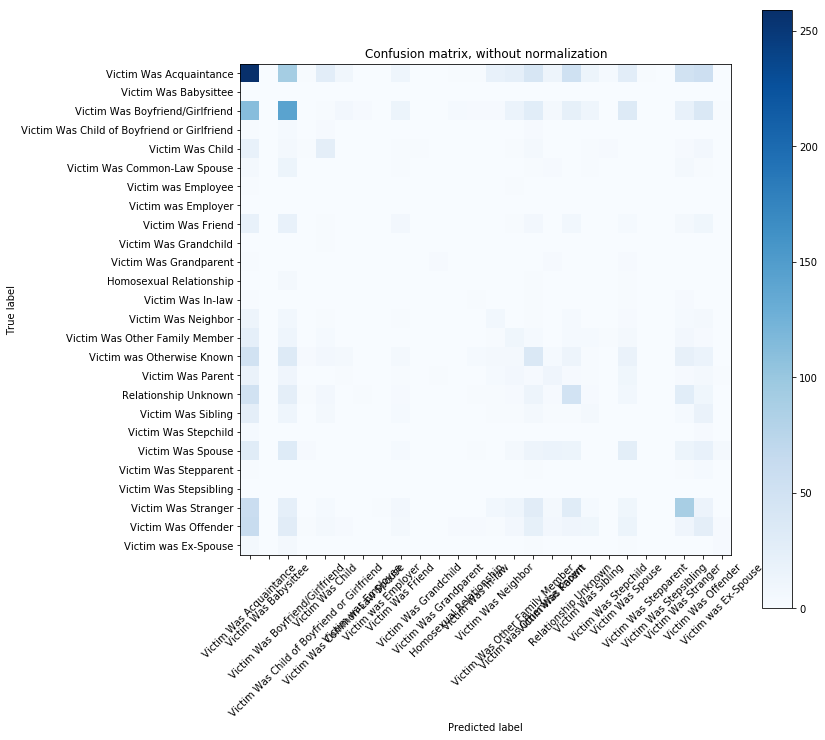

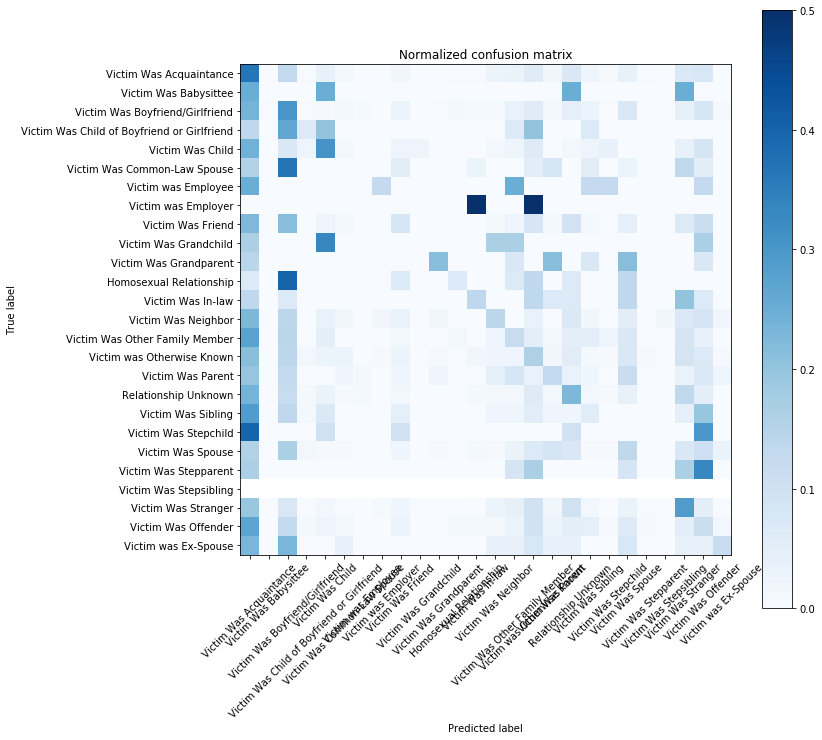

In [139]:
race_label = ['Unknown', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian',
 'Asian, Native Hawaiian, or Other Pacific Islander', 'Chinese', 'Japanese',
 'Native Hawaiian or Other Pacific Islander', 'Other', 'Multiple', 'Not Specified']
race_list = ['Unknown', 'White', 'Black or African Amerian', 'American Indian or Alaska Native', 'Asian']

confusion_matrix_relationship = confusion_matrix(categorial_output[training_size:, 0], categorical_predict_dt[:, 0], labels=relationship_list)
confusion_matrix_sex = confusion_matrix(categorial_output[training_size:, 1], categorical_predict_dt[:, 1], labels=sex_list)
confusion_matrix_race = confusion_matrix(categorial_output[training_size:, 2], categorical_predict_dt[:, 2], labels=race_list)
# confusion_matrix_ethnicity = confusion_matrix(categorial_output[training_size:, 3], categorical_predict_dt[:, 3], labels=ethnicity_list)



# Plot non-normalized confusion matrix
plt.figure(figsize=(11,11))
plot_confusion_matrix(confusion_matrix_relationship, classes=relationship_list,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(11,11))
plot_confusion_matrix(confusion_matrix_relationship, classes=relationship_list, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


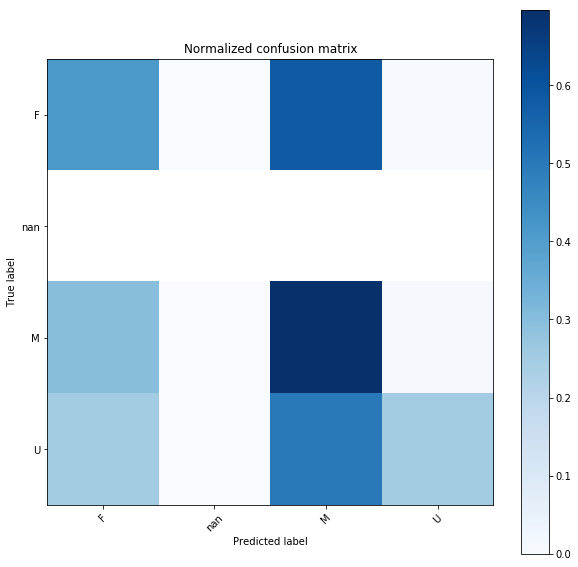

In [137]:
# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix_sex, classes=sex_list, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


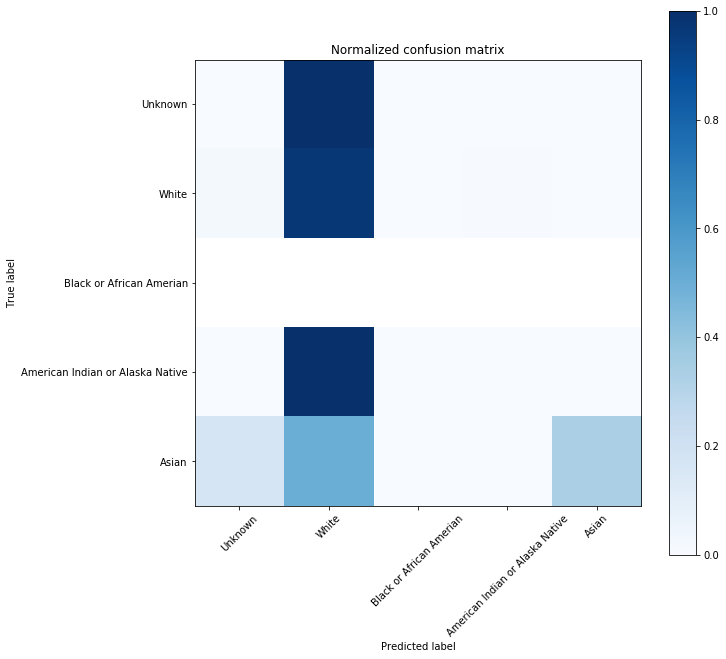

In [138]:
# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix_race, classes=race_list, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
confusion_matrix_ethnicity

In [560]:
# np.set_printoptions(threshold=np.nan)
# print(np.sum((output_offender_race == 'Black or African American')) / output_offender_race.shape[0])
# print(np.sum((output_offender_race == 'Asian')) / output_offender_race.shape[0])
# print(np.sum((output_offender_race == 'White')) / output_offender_race.shape[0])

print('relationship_name_predict decision tree: ', \
      np.sum(relationship_name_predict_dt == output_relationship_name[training_size:]) / output_relationship_name[training_size:].shape[0])
print('relationship_name_predict svc: ',\
      np.sum(relationship_name_predict_svc == output_relationship_name[training_size:]) / output_relationship_name[training_size:].shape[0])


print('offender_sex_predict decision tree: ', \
      np.sum(offender_sex_predict_dt == output_offender_sex[training_size:]) / output_offender_sex[training_size:].shape[0])
print('offender_sex_predict svc: ', \
      np.sum(offender_sex_predict_svc == output_offender_sex[training_size:]) / output_offender_sex[training_size:].shape[0])


print('bias_name_predict decision tree: ',\
      np.sum(bias_name_predict_dt == output_bias_name[training_size:]) / output_bias_name[training_size:].shape[0])
print('bias_name_predict svc: ',\
      bias_name_predict_svc == output_bias_name[training_size:]) / output_bias_name[training_size:].shape[0])

print('offender_race_predit decision tree: ',\
      np.sum(offender_race_predit_dt == output_offender_race[training_size:]) / output_offender_race[training_size:].shape[0])
print('offender_race_predit svc: ',\
      np.sum(offender_race_predit_svc == output_offender_race[training_size:]) / output_offender_race[training_size:].shape[0])

print(np.sum(relationship_name_predict_nb == output_relationship_name[training_size:]) / output_relationship_name[training_size:].shape[0])
print(np.sum(np.absolute(offender_age_predict - output_offender_age[training_size:]) <= 0.05) / output_offender_age[training_size:].shape[0])

0.24
0.6236666666666667
0.9973333333333333
0.766
0.005
0.3396666666666667


Try multi output classifier with naive Bayes...

In [322]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
multi_target_gaussian = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_gaussian.fit(inputFeature.as_matrix(), outputFeature.as_matrix())
multi_target_gaussian.predict(inputFeature.iloc[:10, :].as_matrix())

ValueError: Unknown label type: 'continuous-multioutput'

Explore the accuracy and balance of data...


Plot ROC...

In [284]:
outputFeature.head(10)

,Homosexual Relationship,Relationship Unknown,Victim Was Acquaintance,Victim Was Babysittee,Victim Was Boyfriend/Girlfriend,Victim Was Child,Victim Was Child of Boyfriend or Girlfriend,Victim Was Common-Law Spouse,Victim Was Friend,Victim Was Grandchild,Victim Was Grandparent,Victim Was In-law,Victim Was Neighbor,Victim Was Offender,Victim Was Other Family Member,Victim Was Parent,Victim Was Sibling,Victim Was Spouse,Victim Was Stepchild,Victim Was Stepparent,Victim Was Stepsibling,Victim Was Stranger,Victim was Employee,Victim was Ex-Spouse,Victim was Otherwise Known,Fo,Mo,U,Asiano,Black or African Americano,Unknown,Whiteo,Anti-White,Noneo
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1
